In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch
import EDMDTester

tmp_func = lambda x: x
observable_func = pkdl.ObservableFunction(tmp_func, 2)
config_file = "paramkoopman1000-10.json"

param_solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)
param_solver.setup(observable_func)
param_solver.dictionary.load("data/paramkoopman1000-10_dict.pt")
param_solver.K.load("data/paramkoopman1000-10_koopman.pt")
param_K = param_solver.K

num_param = 10
config_file = "EDMD-RBF.json"
edmd_solver = EDMDTester.EDMDTester(
    config_file,
    num_param,
    observable_func,
    param_min=torch.tensor([0.0, -2.0, 0.0]),
    param_max=torch.tensor([1.0, 2.0, 2.0]),
    seed_param=param_solver.seed_param,
    is_edmd=True
)
config_file = "EDMDDL.json"
edmddl_solver = EDMDTester.EDMDTester(
    config_file,
    num_param,
    observable_func,
    param_min=torch.tensor([0.0, -2.0, 0.0]),
    param_max=torch.tensor([1.0, 2.0, 2.0]),
    seed_param=param_solver.seed_param,
    is_edmd=False
)

2024-11-29 13:25:05,726 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating data...
2024-11-29 13:25:05,754 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating trajectories...
Generating trajectories: 100%|██████████| 49/49 [00:02<00:00, 21.98it/s]
2024-11-29 13:25:07,991 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating labels...
2024-11-29 13:25:08,457 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Data generated.
/home/yxqian/code/deep_learning/Para-Koopman-Learning/PKoopmanDL/Dictionary.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed dur

## Plot

In [2]:
param = torch.tensor([[0.5, 0.0, 0.5]]).detach()
x_min = param_solver.x_min
x_max = param_solver.x_max
traj_len = param_solver.traj_len
dynamics = param_solver.dynamics
state_pos = [0,1]

# Solving via EDMD and EDMDDL
edmd_K, edmd_dictionary = edmd_solver.solve(param)
edmddl_K, edmddl_dictionary = edmddl_solver.solve(param)


dataset_predict = pkdl.KoopmanDataSet(dynamics)
dataset_predict.generate_data(1, traj_len, x_min, x_max, param)

2024-11-29 13:26:09,818 PKoopmanDL: [INFO] [EDMDSolver] Solving...
2024-11-29 13:26:16,394 PKoopmanDL: [INFO] [EDMDDLSolver] Solving...
Training: 100%|██████████| 100/100 [16:44<00:00, 10.04s/it, train_loss=5.65e-03, val_loss=2.26e-03]


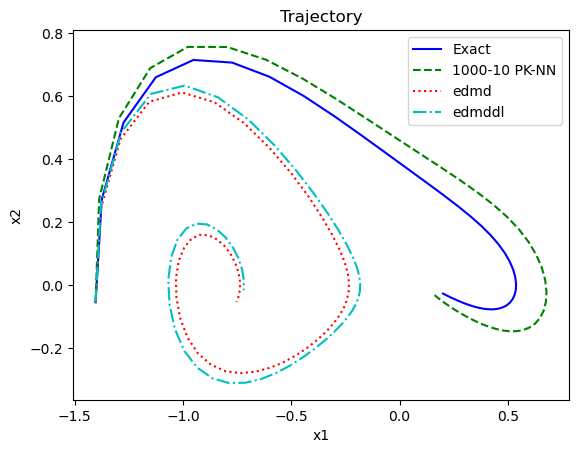

In [3]:
x_traj = dataset_predict.data_x
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
param_dynamics = pkdl.KoopmanDynamics(param_K, param_solver.dictionary, state_pos, 2)
param_p = param_dynamics.traj(x0, param, traj_len).detach()
param_x_est_traj = param_p[0, :, :]
edmd_dynamics = pkdl.KoopmanDynamics(edmd_K, edmd_dictionary, state_pos, 2)
edmd_p = edmd_dynamics.traj(x0, None, traj_len).detach()
edmd_x_est_traj = edmd_p[0, :, :]
edmddl_dynamics = pkdl.KoopmanDynamics(edmddl_K, edmddl_dictionary, state_pos, 2)
edmddl_p = edmddl_dynamics.traj(x0, None, traj_len).detach()
edmddl_x_est_traj = edmddl_p[0, :, :]


plt.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', color='b', label='Exact')
plt.plot(param_x_est_traj[:, 0], param_x_est_traj[:, 1], linestyle='--', color='g', label='1000-10 PK-NN')
plt.plot(edmd_x_est_traj[:, 0], edmd_x_est_traj[:, 1], linestyle=':', color='r', label='edmd')
plt.plot(edmddl_x_est_traj[:, 0], edmddl_x_est_traj[:, 1], linestyle='-.', color='c', label='edmddl')


plt.title('Trajectory')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()